In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
conn= engine.connect()

In [9]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()

In [10]:
Base.prepare(engine, reflect=True)

In [11]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [13]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
inspector = inspect(engine)

In [17]:
columns = inspector.get_columns('measurement')
for col in columns:
    print(col['name'])

id
station
date
prcp
tobs


# Exploratory Climate Analysis

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute("select date from Measurement order by date desc limit 1")
for x in last_date:
    print(x)

('2017-08-23',)


In [33]:
# Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute("select date from Measurement order by date desc limit 1")
for x in last_date:
    print(x)

('2017-08-23',)


In [38]:
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [93]:
#Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).all()

In [63]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
new_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

In [67]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df =pd.DataFrame(new_data, columns=['date','prcp'])
df.set_index(df['date'], inplace=True)
df=df.dropna()
df

,date,prcp
date,,
2016-08-23,2016-08-23,0.00
2016-08-23,2016-08-23,0.15
2016-08-23,2016-08-23,0.05
2016-08-23,2016-08-23,0.02
2016-08-23,2016-08-23,1.79
...,...,...
2017-08-22,2017-08-22,0.50
2017-08-23,2017-08-23,0.00
2017-08-23,2017-08-23,0.00


In [95]:
data_02 = session.query(Measurement.date, Measurement.prcp, Measurement.station, Measurement.tobs).all()

In [97]:
df_new =pd.DataFrame(data_02, columns=['date','prcp','station','tobs'])
df_new

,date,prcp,station,tobs
0,2010-01-01,0.08,USC00519397,65.0
1,2010-01-02,0.00,USC00519397,63.0
2,2010-01-03,0.00,USC00519397,74.0
3,2010-01-04,0.00,USC00519397,76.0
4,2010-01-06,NaN,USC00519397,73.0
...,...,...,...,...
19545,2017-08-19,0.09,USC00516128,71.0
19546,2017-08-20,NaN,USC00516128,78.0
19547,2017-08-21,0.56,USC00516128,76.0
19548,2017-08-22,0.50,USC00516128,76.0


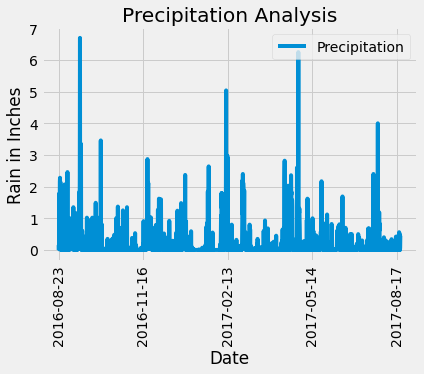

In [79]:
# Use Pandas Plotting with Matplotlib to plot the data
df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"], loc='upper right')
plt.xticks(rotation=90)
plt.show()

In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [82]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).count()
station_count

19550

In [118]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [124]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station =='USC00519523').all()
highest_temp = session.query(func.max(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station =='USC00519523').all()
avg_temp = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).filter(Measurement.station =='USC00519523').all()
print(lowest_temp, highest_temp, avg_temp)

[(56.0,)] [(85.0,)] [(74.5436493068565,)]


In [133]:
# Choose the station with the highest number of temperature observations.
highest_obs = session.query(Measurement.tobs, Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()
highest_obs
print(f"The station with highest number of observations is {highest_obs[0][1]} ")



The station with highest number of observations is USC00519281 


In [138]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_obs = session.query(Measurement.tobs, Measurement.station).filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).filter(Measurement.station =='USC00519281').all()


In [140]:
temp_df = pd.DataFrame(station_obs, columns=['tobs', 'station'])
temp_df

,tobs,station
0,77.0,USC00519281
1,77.0,USC00519281
2,80.0,USC00519281
3,80.0,USC00519281
4,75.0,USC00519281
...,...,...
347,77.0,USC00519281
348,77.0,USC00519281
349,76.0,USC00519281
350,76.0,USC00519281


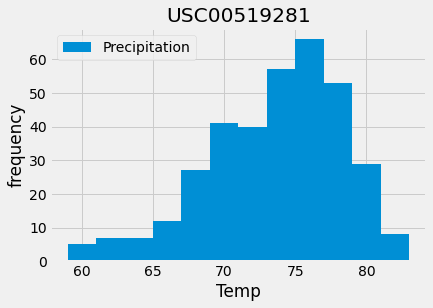

<Figure size 432x288 with 0 Axes>

In [148]:
hist = temp_df['tobs'].hist(bins=12)
plt.xlabel("Temp")
plt.ylabel("frequency")
plt.title("USC00519281")
plt.legend(["Precipitation"], loc='upper left')
plt.show()
plt.savefig("USC00519281")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
